# Parkings forecasting with Prophet for Puutarhakatu 6

## Initial setup

In [26]:
import pandas as pd
import numpy as np
import warnings
import logging
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

from utils import (get_forecast_total_sum, cross_validate, optimize_prophet_params,
                   print_best_params, percent_difference)

In [27]:
warnings.filterwarnings("ignore", category=FutureWarning)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

## Data loading and cleaning

In [28]:
df = pd.read_csv("../data/parkings_small.csv") # all zones
df = df[df['parking_area_id'] == '318a1ad2-5e33-488c-85bb-c3e9644c4942'] # puutarhakatu 6
df['time_start'] = pd.to_datetime(df['time_start'], format="ISO8601")
df['time_end'] = pd.to_datetime(df['time_end'], format="ISO8601")

In [29]:
rain_df = pd.read_csv('../data/artukainen_rain.csv')
rain_df['timestamp'] = pd.to_datetime(rain_df['timestamp'])
rain_df = rain_df.rename(columns={"timestamp": "ds", "value": "rain"})

In [30]:
temp_df = pd.read_csv('../data/artukainen_temperature.csv')
temp_df['timestamp'] = pd.to_datetime(temp_df['timestamp'])
temp_df = temp_df.rename(columns={"timestamp": "ds", "value": "temp"})

### Hourly time series for parking occupancy

In [31]:

# Generate hourly timestamps for each hour eg 0, 1, 2
hourly_index = pd.date_range(start=df['time_start'].min().floor('h'),
                             end=df['time_end'].max().ceil('h'),
                             freq='h')

# Initialize an empty DataFrame for hourly occupancy counts
hourly_parking = pd.DataFrame({'ds': hourly_index})

# Count active parkings in each hour
def count_active_parkings(timestamp):
    return ((df['time_start'] <= timestamp) & (df['time_end'] > timestamp)).sum()
    # time stamp is between start and end time of parking

hourly_parking['y'] = hourly_parking['ds'].apply(count_active_parkings)
hourly_parking['ds'] = hourly_parking['ds'].dt.tz_localize(None)
hourly_parking.head()

,ds,y
0,2024-05-20 05:00:00,0
1,2024-05-20 06:00:00,1
2,2024-05-20 07:00:00,0
3,2024-05-20 08:00:00,1
4,2024-05-20 09:00:00,0


### Rain and temperature data merging

In [32]:
# Merge rain data
hourly_parking = pd.merge(hourly_parking, rain_df, on='ds', how='left')
# 3mm of rain is considered as rain
hourly_parking['rain_bool'] = hourly_parking['rain'] >= 3.0
# Merge temperature data
hourly_parking = pd.merge(hourly_parking, temp_df, on='ds', how='left')
hourly_parking.tail()

,ds,y,rain,rain_bool,temp
6294,2025-02-06 11:00:00,3,0.0,False,2.1
6295,2025-02-06 12:00:00,2,0.0,False,2.9
6296,2025-02-06 13:00:00,2,0.0,False,3.1
6297,2025-02-06 14:00:00,1,0.0,False,3.0
6298,2025-02-06 15:00:00,0,0.0,False,1.9


## Prophet model parameter testing

In [33]:
#best_params_rmse, results_df_rmse = optimize_prophet_params(hourly_parking, target_metric='rmse')
#print_best_params(best_params_rmse, results_df_rmse)
''' results
Best Parameters:
changepoint_prior_scale: 0.001
seasonality_prior_scale: 0.1
seasonality_mode: additive
changepoint_range: 0.85
interval_width: 0.95
Best score: 1.22

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score
10                    0.001                      0.1         additive               0.85            0.95  1.224026
11                    0.001                      0.1         additive               0.85            0.99  1.224026
18                    0.001                      1.0         additive               0.85            0.95  1.224175
19                    0.001                      1.0         additive               0.85            0.99  1.224175
34                    0.001                    100.0         additive               0.85            0.95  1.224700
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.001\nseasonality_prior_scale: 0.1\nseasonality_mode: additive\nchangepoint_range: 0.85\ninterval_width: 0.95\nBest score: 1.22\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score\n10                    0.001                      0.1         additive               0.85            0.95  1.224026\n11                    0.001                      0.1         additive               0.85            0.99  1.224026\n18                    0.001                      1.0         additive               0.85            0.95  1.224175\n19                    0.001                      1.0         additive               0.85            0.99  1.224175\n34                    0.001                    100.0         additive               0.85            0.95  1.224700\n'

In [34]:
#best_params_rmse_rain, results_df_rmse_rain = optimize_prophet_params(hourly_parking, target_metric='rmse', incl_rain=True)
#print_best_params(best_params_rmse_rain, results_df_rmse_rain)
''' results
Best Parameters:
changepoint_prior_scale: 0.001
seasonality_prior_scale: 10.0
seasonality_mode: additive
changepoint_range: 0.85
interval_width: 0.95
Best score: 1.22

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score
27                    0.001                     10.0         additive               0.85            0.99  1.223910
26                    0.001                     10.0         additive               0.85            0.95  1.223910
34                    0.001                    100.0         additive               0.85            0.95  1.224247
35                    0.001                    100.0         additive               0.85            0.99  1.224247
18                    0.001                      1.0         additive               0.85            0.95  1.224760
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.001\nseasonality_prior_scale: 10.0\nseasonality_mode: additive\nchangepoint_range: 0.85\ninterval_width: 0.95\nBest score: 1.22\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score\n27                    0.001                     10.0         additive               0.85            0.99  1.223910\n26                    0.001                     10.0         additive               0.85            0.95  1.223910\n34                    0.001                    100.0         additive               0.85            0.95  1.224247\n35                    0.001                    100.0         additive               0.85            0.99  1.224247\n18                    0.001                      1.0         additive               0.85            0.95  1.224760\n'

In [35]:
#best_params_rmse_temp, results_df_rmse_temp = optimize_prophet_params(hourly_parking, target_metric='rmse', incl_temp=True)
#print_best_params(best_params_rmse_temp, results_df_rmse_temp)
''' results
Best Parameters:
changepoint_prior_scale: 0.001
seasonality_prior_scale: 10.0
seasonality_mode: additive
changepoint_range: 0.9
interval_width: 0.95
Best score: 1.23

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score
29                    0.001                     10.0         additive                0.9            0.99  1.232832
28                    0.001                     10.0         additive                0.9            0.95  1.232832
12                    0.001                      0.1         additive                0.9            0.95  1.232993
13                    0.001                      0.1         additive                0.9            0.99  1.232993
36                    0.001                    100.0         additive                0.9            0.95  1.233128
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.001\nseasonality_prior_scale: 10.0\nseasonality_mode: additive\nchangepoint_range: 0.9\ninterval_width: 0.95\nBest score: 1.23\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score\n29                    0.001                     10.0         additive                0.9            0.99  1.232832\n28                    0.001                     10.0         additive                0.9            0.95  1.232832\n12                    0.001                      0.1         additive                0.9            0.95  1.232993\n13                    0.001                      0.1         additive                0.9            0.99  1.232993\n36                    0.001                    100.0         additive                0.9            0.95  1.233128\n'

In [36]:
#best_params_rmse_rain_temp, results_df_rmse_rain_temp = optimize_prophet_params(hourly_parking, target_metric='rmse', incl_rain=True, incl_temp=True)
#print_best_params(best_params_rmse_rain_temp, results_df_rmse_rain_temp)
''' results
Best Parameters:
changepoint_prior_scale: 0.001
seasonality_prior_scale: 1.0
seasonality_mode: additive
changepoint_range: 0.9
interval_width: 0.95
Best score: 1.23

Top 5 Parameter Combinations:
    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score
20                    0.001                      1.0         additive                0.9            0.95  1.232687
21                    0.001                      1.0         additive                0.9            0.99  1.232687
12                    0.001                      0.1         additive                0.9            0.95  1.233256
13                    0.001                      0.1         additive                0.9            0.99  1.233256
24                    0.001                     10.0         additive                0.8            0.95  1.233732
'''

' results\nBest Parameters:\nchangepoint_prior_scale: 0.001\nseasonality_prior_scale: 1.0\nseasonality_mode: additive\nchangepoint_range: 0.9\ninterval_width: 0.95\nBest score: 1.23\n\nTop 5 Parameter Combinations:\n    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  changepoint_range  interval_width     score\n20                    0.001                      1.0         additive                0.9            0.95  1.232687\n21                    0.001                      1.0         additive                0.9            0.99  1.232687\n12                    0.001                      0.1         additive                0.9            0.95  1.233256\n13                    0.001                      0.1         additive                0.9            0.99  1.233256\n24                    0.001                     10.0         additive                0.8            0.95  1.233732\n'

## Prophet model and forecast

In [37]:
# Function to create a model and forecast
def create_model_and_forecast(df, interval_width=0.95, changepoint_prior_scale=0.01, seasonality_prior_scale=10.0,
                              seasonality_mode='additive', changepoint_range=0.85, rain=None, rain_bool=False, temp=None):
    m = Prophet(
        interval_width=interval_width,
        changepoint_prior_scale=changepoint_prior_scale,
        changepoint_range=changepoint_range,
        seasonality_prior_scale=seasonality_prior_scale,
        seasonality_mode=seasonality_mode,
    )
    m.add_country_holidays(country_name='FI')
    if rain:
        m.add_regressor('rain')
    if rain_bool:
        m.add_regressor('rain_bool')
    if temp:
        m.add_regressor('temp')
    m.fit(df)

    days = 30
    forecast_days = 24*days
    future = m.make_future_dataframe(periods=forecast_days, freq='h')
    last_date = future['ds'].max()
    start_date = last_date - pd.Timedelta(days=days-1)
    if rain:
        future = pd.merge(future, rain_df, on='ds', how='left')
        future.loc[future['ds'] >= start_date, 'rain'] = rain
    if rain_bool:
        if rain is None:
            future = pd.merge(future, rain_df, on='ds', how='left')       
        future['rain_bool'] = future['rain'] >= 3.0
        future.loc[future['ds'] >= start_date, 'rain_bool'] = True
    if temp:
        future = pd.merge(future, temp_df, on='ds', how='left')
        future.loc[future['ds'] >= start_date, 'temp'] = temp

    forecast = m.predict(future)
    forecast['yhat'] = np.round(np.maximum(forecast['yhat'], 0))
    forecast['yhat_lower'] = np.round(np.maximum(forecast['yhat_lower'], 0))
    forecast['yhat_upper'] = np.round(np.maximum(forecast['yhat_upper'], 0))
    return m, forecast

In [38]:
baseline_model, baseline_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                              changepoint_prior_scale=0.001,
                                                              seasonality_prior_scale=0.1,
                                                              seasonality_mode='additive',
                                                              changepoint_range=0.85,
                                                              rain=None, rain_bool=False, temp=None)

rain_model, rain_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                      changepoint_prior_scale=0.001,
                                                      seasonality_prior_scale=10.0,
                                                      seasonality_mode='additive',
                                                      changepoint_range=0.85,
                                                      rain=3.0, rain_bool=False, temp=None)

rain_bool_model, rain_bool_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                                changepoint_prior_scale=0.001,
                                                                seasonality_prior_scale=10.0,
                                                                seasonality_mode='additive',
                                                                changepoint_range=0.85,
                                                                rain=None, rain_bool=True, temp=None)

temp_params = {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive',
               'changepoint_range': 0.9, 'interval_width': 0.95}

temp_model_minus20, temp_forecast_minus20 = create_model_and_forecast(hourly_parking, **temp_params, temp=-20)
temp_model_minus10, temp_forecast_minus10 = create_model_and_forecast(hourly_parking, **temp_params, temp=-10)
temp_model_0, temp_forecast_0 = create_model_and_forecast(hourly_parking, **temp_params, temp=0)
temp_model_plus10, temp_forecast_plus10 = create_model_and_forecast(hourly_parking, **temp_params, temp=10)
temp_model_plus20, temp_forecast_plus20 = create_model_and_forecast(hourly_parking, **temp_params, temp=20)

rain_temp_model, rain_temp_forecast = create_model_and_forecast(hourly_parking, interval_width=0.95,
                                                                changepoint_prior_scale=0.001,
                                                                seasonality_prior_scale=1.0,
                                                                seasonality_mode='additive',
                                                                changepoint_range=0.9,
                                                                rain=3.0, rain_bool=False, temp=20)

### Total parkings in forecasts

In [39]:
# total parkings in forecast
start_date = hourly_parking['ds'].max()
end_date = start_date + pd.Timedelta(days=30)
print(f'Forecast period: {start_date} - {end_date}')

base_total = get_forecast_total_sum(baseline_forecast, start_date, end_date)
rain_total = get_forecast_total_sum(rain_forecast, start_date, end_date)
rain_bool_total = get_forecast_total_sum(rain_bool_forecast, start_date, end_date)
temp_minus20_total = get_forecast_total_sum(temp_forecast_minus20, start_date, end_date)
temp_minus10_total = get_forecast_total_sum(temp_forecast_minus10, start_date, end_date)
temp_0_total = get_forecast_total_sum(temp_forecast_0, start_date, end_date)
temp_plus10_total = get_forecast_total_sum(temp_forecast_plus10, start_date, end_date)
temp_plus20_total = get_forecast_total_sum(temp_forecast_plus20, start_date, end_date)
rain_temp_plus20_total = get_forecast_total_sum(rain_temp_forecast, start_date, end_date)
print(f'Baseline forecast cars: {base_total}')
print(f'Rain forecast cars: {rain_total}. Diff to baseline: {rain_total-base_total} ({percent_difference(base_total, rain_total)}%)')
print(f'Rain bool forecast cars: {rain_bool_total}. Diff to baseline: {rain_bool_total-base_total} ({percent_difference(base_total, rain_bool_total)}%)')
print(f'Temp -20 forecast cars: {temp_minus20_total}. Diff to baseline: {temp_minus20_total-base_total} ({percent_difference(base_total, temp_minus20_total)}%)')
print(f'Temp -10 forecast cars: {temp_minus10_total}. Diff to baseline: {temp_minus10_total-base_total} ({percent_difference(base_total, temp_minus10_total)}%)')
print(f'Temp 0 forecast cars: {temp_0_total}. Diff to baseline: {temp_0_total-base_total} ({percent_difference(base_total, temp_0_total)}%)')
print(f'Temp +10 forecast cars: {temp_plus10_total}. Diff to baseline: {temp_plus10_total-base_total} ({percent_difference(base_total, temp_plus10_total)}%)')
print(f'Temp +20 forecast cars: {temp_plus20_total}. Diff to baseline: {temp_plus20_total-base_total} ({percent_difference(base_total, temp_plus20_total)}%)')
print(f'Rain & Temp +20 forecast cars: {rain_temp_plus20_total}. Diff to baseline: {rain_temp_plus20_total-base_total} ({percent_difference(base_total, rain_temp_plus20_total)}%)')

Forecast period: 2025-02-06 15:00:00 - 2025-03-08 15:00:00
Baseline forecast cars: 822.0
Rain forecast cars: 780.0. Diff to baseline: -42.0 (-5.11%)
Rain bool forecast cars: 815.0. Diff to baseline: -7.0 (-0.85%)
Temp -20 forecast cars: 939.0. Diff to baseline: 117.0 (14.23%)
Temp -10 forecast cars: 914.0. Diff to baseline: 92.0 (11.19%)
Temp 0 forecast cars: 827.0. Diff to baseline: 5.0 (0.61%)
Temp +10 forecast cars: 875.0. Diff to baseline: 53.0 (6.45%)
Temp +20 forecast cars: 857.0. Diff to baseline: 35.0 (4.26%)
Rain & Temp +20 forecast cars: 821.0. Diff to baseline: -1.0 (-0.12%)


### Forecast plotting

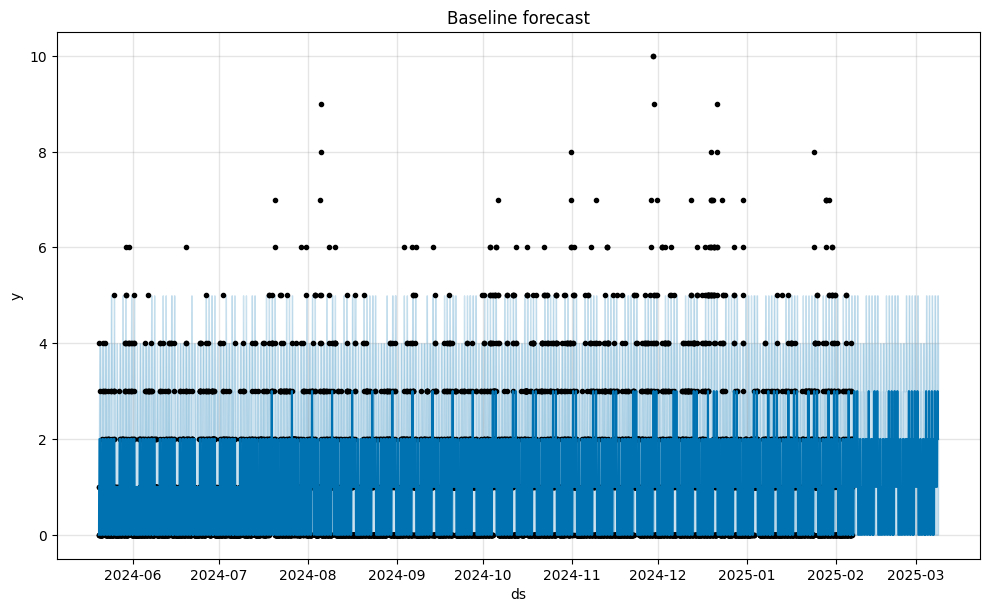

Baseline forecast components


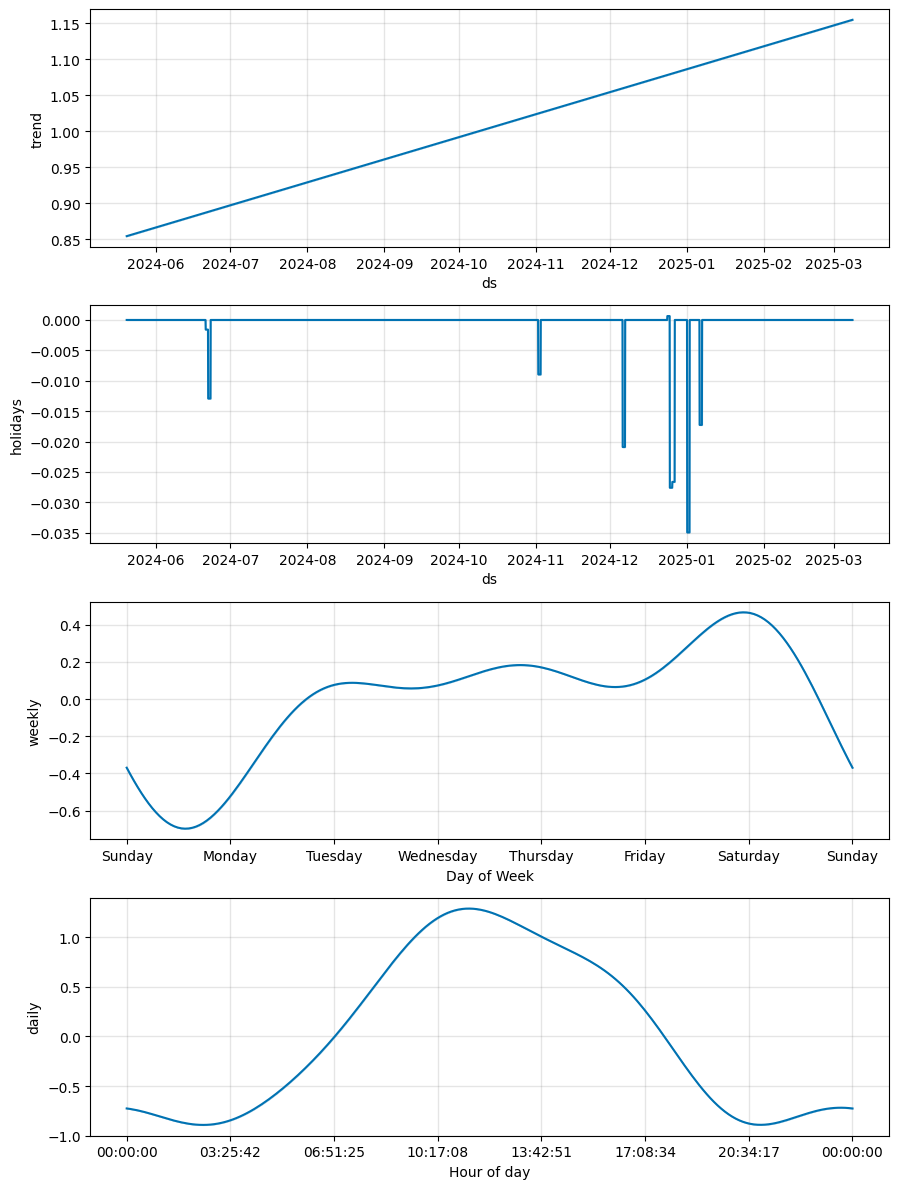

In [40]:
fig = baseline_model.plot(baseline_forecast)
plt.title('Baseline forecast')
plt.show()
fig2 = baseline_model.plot_components(baseline_forecast)
print('Baseline forecast components')
plt.show()

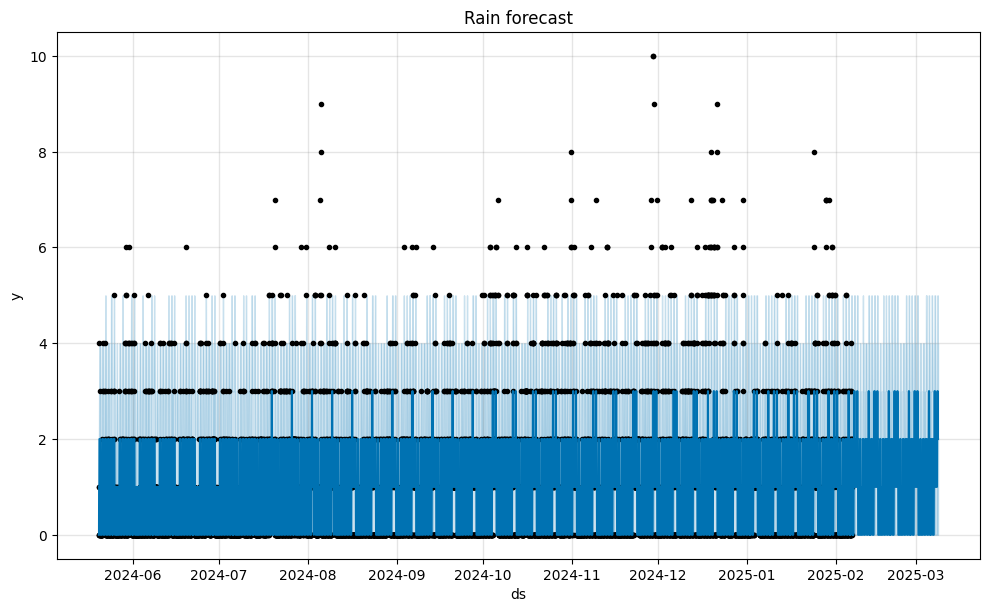

Rain forecast components


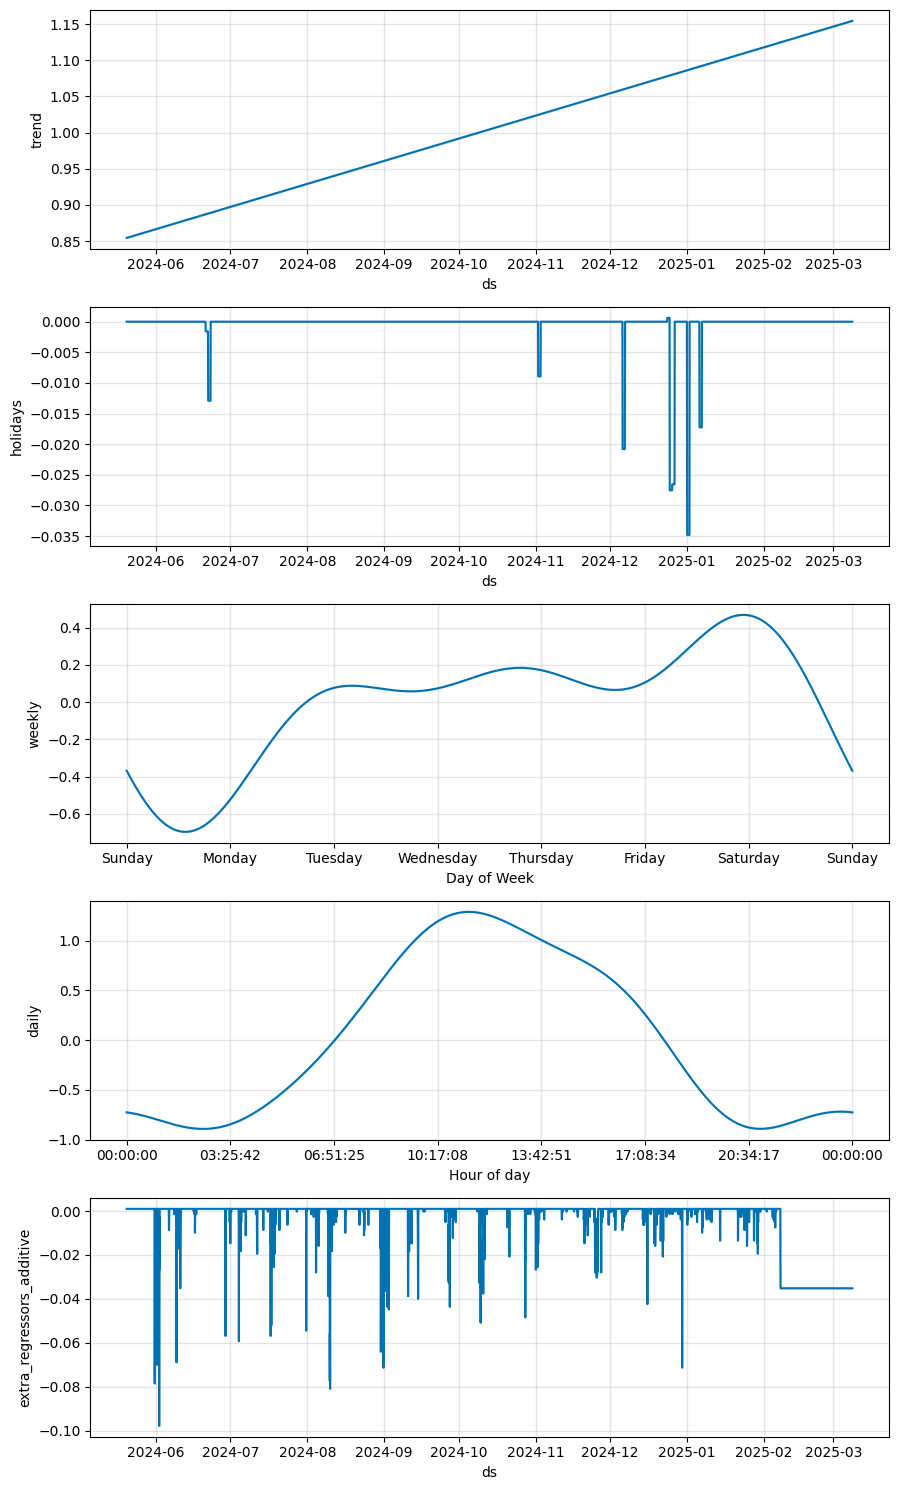

In [41]:
fig = rain_model.plot(rain_forecast)
plt.title('Rain forecast')
plt.show()
fig2 = rain_model.plot_components(rain_forecast)
print('Rain forecast components')
plt.show()

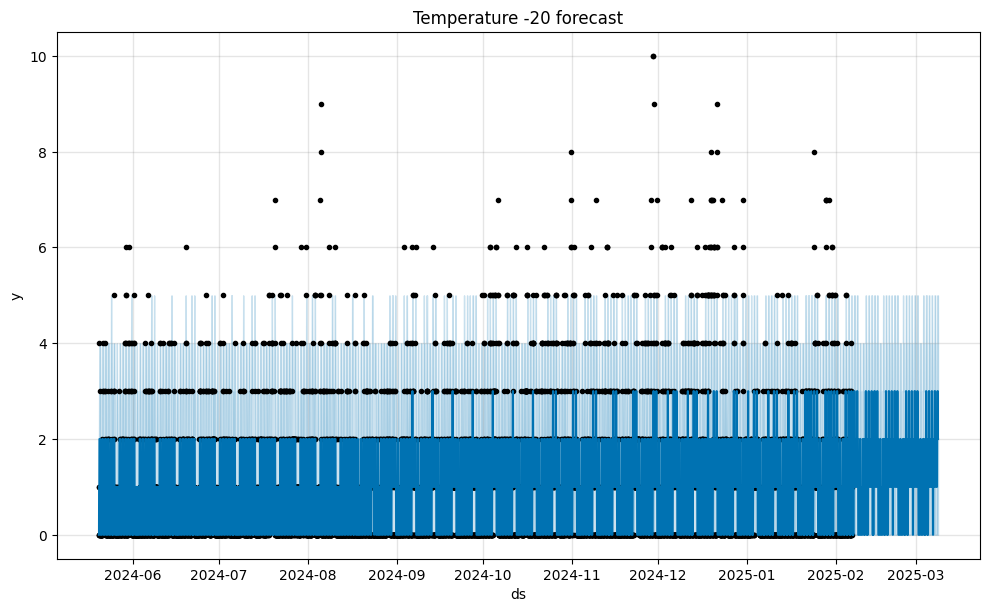

Temperature -20 forecast components


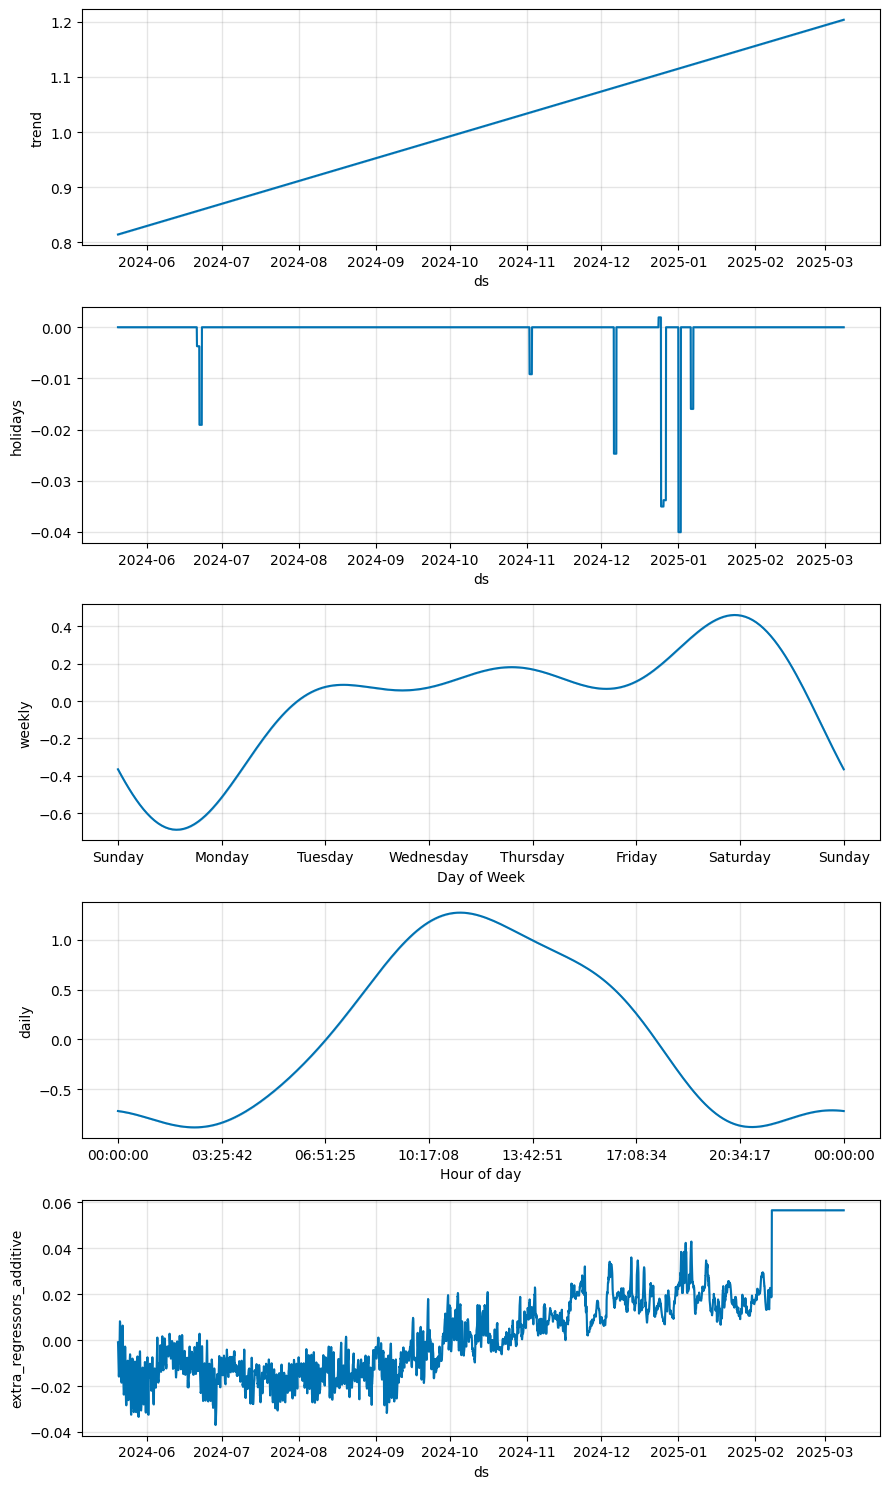

In [42]:
fig = temp_model_minus20.plot(temp_forecast_minus20)
plt.title('Temperature -20 forecast')
plt.show()
fig2 = temp_model_minus20.plot_components(temp_forecast_minus20)
print('Temperature -20 forecast components')
plt.show()

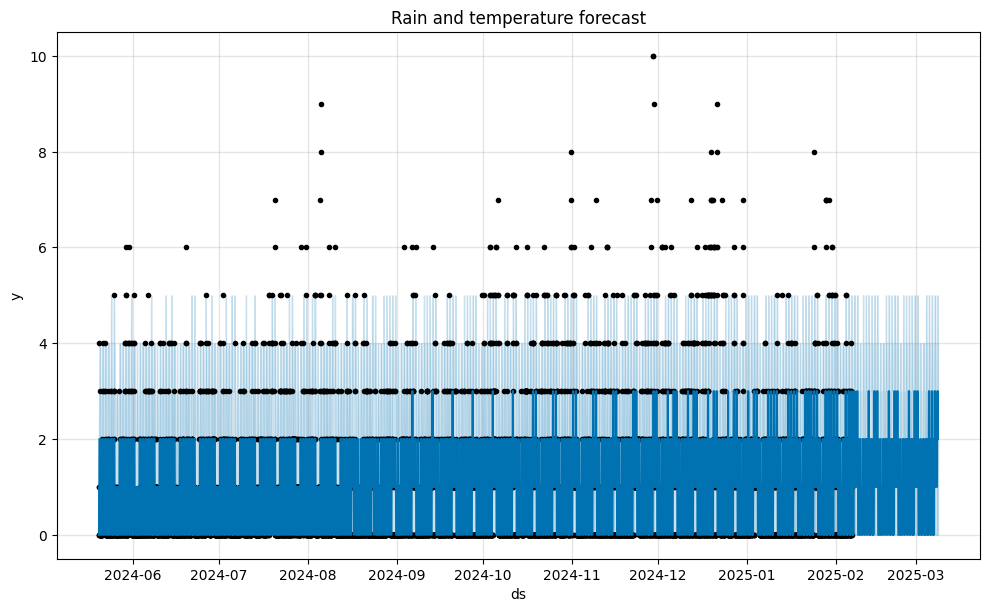

Rain and temperature forecast components


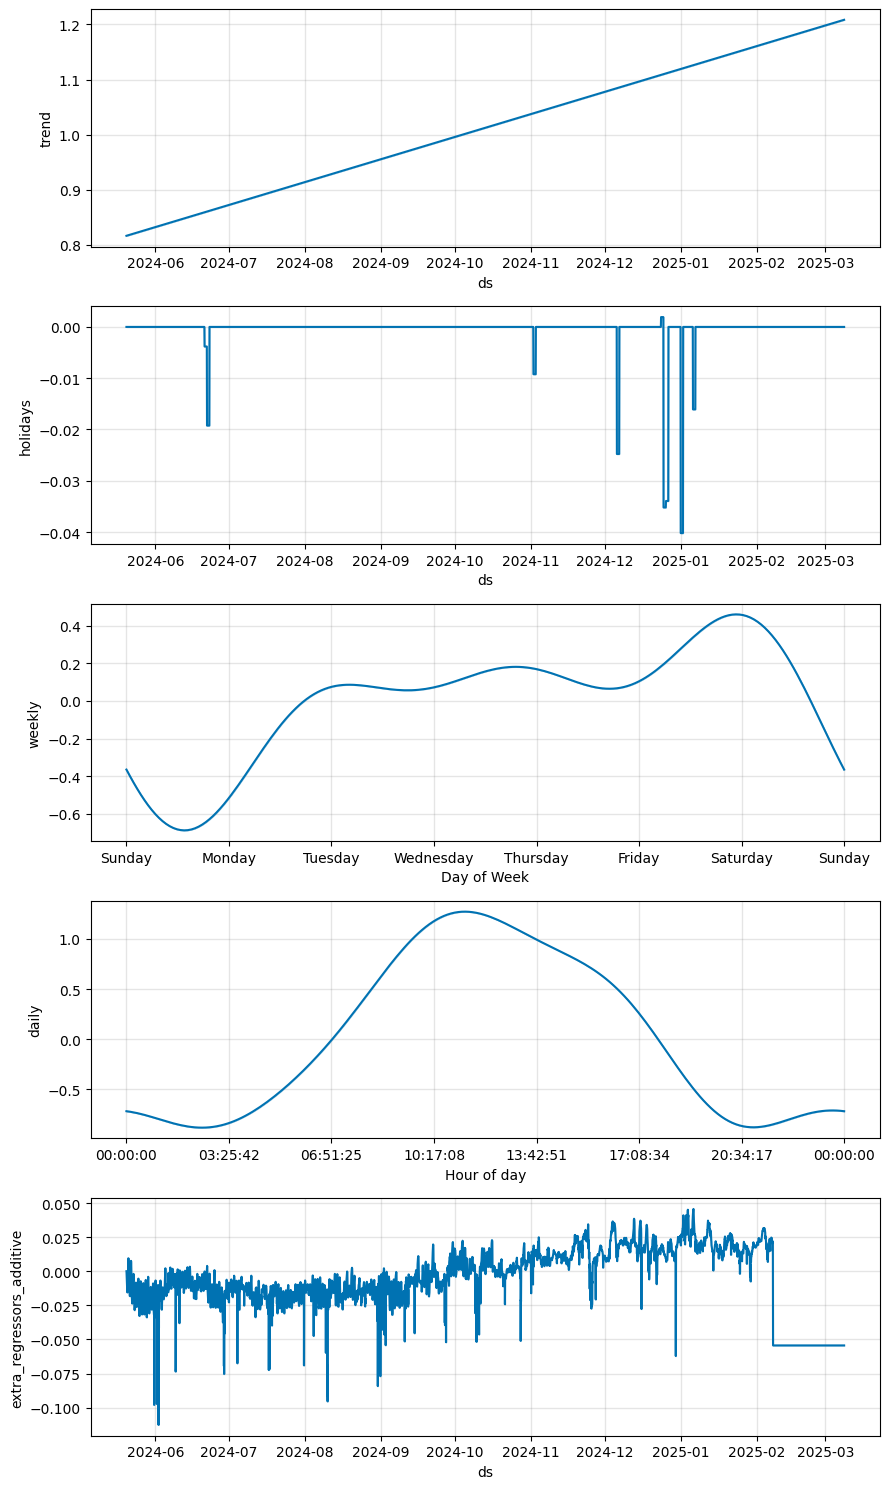

In [43]:
fig = rain_temp_model.plot(rain_temp_forecast)
plt.title('Rain and temperature forecast')
plt.show()
fig2 = rain_temp_model.plot_components(rain_temp_forecast)
print('Rain and temperature forecast components')
plt.show()

## Model performance metrics

In [44]:
base_cv = cross_validate(baseline_model, initial='120 days', period='7 days', horizon='14 days')
base_cv_p = performance_metrics(base_cv)
base_cv_p.head()
print('Baseline forecast performance metrics:')
print(base_cv_p.mean().to_string())

100%|██████████| 19/19 [00:04<00:00,  4.43it/s]

Baseline forecast performance metrics:
horizon     7 days 17:00:00
mse                1.532725
rmse               1.224026
mae                0.897311
mdape                   inf
smape              1.316892
coverage           0.906307


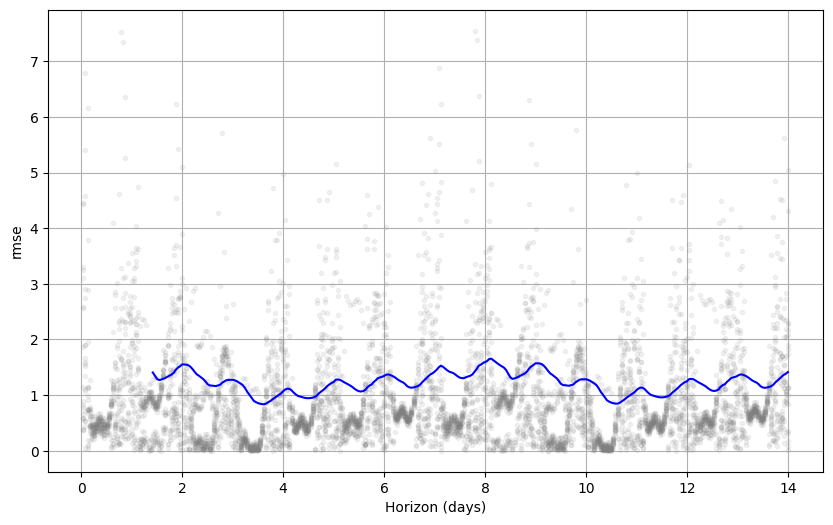

In [45]:
fig = plot_cross_validation_metric(base_cv, metric='rmse')

In [46]:
rain_cv = cross_validate(rain_model, initial='120 days', period='7 days', horizon='14 days')
rain_cv_p = performance_metrics(rain_cv)
rain_cv_p.head()
print('Rain forecast performance metrics:')
print(rain_cv_p.mean().to_string())

  0%|          | 0/19 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:04<00:00,  4.43it/s]

Rain forecast performance metrics:
horizon     7 days 17:00:00
mse                1.532569
rmse                1.22391
mae                 0.89936
mdape                   inf
smape              1.315752
coverage           0.905632


In [47]:
rain_bool_cv = cross_validate(rain_bool_model, initial='120 days', period='7 days', horizon='14 days')
rain_bool_cv_p = performance_metrics(rain_bool_cv)
rain_bool_cv_p.head()
print('Rain bool forecast performance metrics:')
print(rain_bool_cv_p.mean().to_string())

100%|██████████| 19/19 [00:04<00:00,  4.47it/s]

Rain bool forecast performance metrics:
horizon     7 days 17:00:00
mse                1.532683
rmse               1.224038
mae                0.899843
mdape                   inf
smape              1.315377
coverage           0.907717


In [48]:
temp_minus20_cv = cross_validate(temp_model_minus20, initial='120 days', period='7 days', horizon='14 days')
temp_minus20_cv_p = performance_metrics(temp_minus20_cv)
temp_minus20_cv_p.head()
print('Temp forecast performance metrics:')
print(temp_minus20_cv_p.mean().to_string())

100%|██████████| 19/19 [00:04<00:00,  4.30it/s]

Temp forecast performance metrics:
horizon     7 days 17:00:00
mse                1.555917
rmse               1.232832
mae                0.895315
mdape                   inf
smape              1.325887
coverage            0.90285


In [25]:
rain_temp20_cv = cross_validate(rain_temp_model, initial='120 days', period='7 days', horizon='14 days')
rain_temp20_cv_p = performance_metrics(rain_temp20_cv)
rain_temp20_cv_p.head()
print('Rain+temp forecast performance metrics:')
print(rain_temp20_cv_p.mean().to_string())

  0%|          | 0/19 [00:00<?, ?it/s]10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 1/19 [00:00<00:03,  5.21it/s]10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 2/19 [00:00<00:03,  5.62it/s]10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
 16%|█▌        | 3/19 [00:00<00:02,  5.47it/s]10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
 21%|██        | 4/19 [00:00<00:02,  5.34it/s]10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
 26%|██▋       | 5/19 [00:00<00:02,  5.29it/s]10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
 32%|███▏      | 6/19 [00:01<00:02,  4.89it/s]10:50:48

Rain+temp forecast performance metrics:
horizon     7 days 17:00:00
mse                1.555385
rmse               1.232687
mae                0.895333
mdape                   inf
smape              1.325884
coverage           0.903849


## Conclusions

### Model Accuracy Assessment

- **Error Magnitude**: RMSE (1.2) and MAE (0.9) indicate moderate forecasting errors (range 0-10).
- **Percentage Errors**:MDAPE (∞) and SMAPE (132%) are not useful metrics due to values being near to zero.
- **Coverage** (90%) is decent.

### Model Comparison

- Performance metrics across all baseline and weather models are nearly identical.
- Prophet forecasting with different rain and temperature parameters does not significantly improve or change forecasting accuracy.

## Weather Impact Analysis

Weather impact was measured by forecasting 30 days in future with given static weather values. Forecast total cars is a sum of all hourly cars in the 30 day period.

| Scenario | Forecast (Cars) | Difference from Baseline | Percentage Change |
|----------|----------------:|------------------------:|------------------:|
| Baseline | 822.0 | - | - |
| Rain | 780.0 | -42.0 | -5.1% |
| Rain Boolean | 815.0 | -7.0 | -0.9% |
| Temp -20°C | 939.0 | +117.0 | +14.2% |
| Temp -10°C | 914.0 | +92.0 | +11.2% |
| Temp 0°C | 827.0 | +5.0 | +0.6% |
| Temp +10°C | 875.0 | +53.0 | +6.4% |
| Temp +20°C | 857.0 | +35.0 | +4.3% |
| Rain & Temp +20°C | 821.0 | -1.0 | -0.1% |

### Weather Effects Analysis
1. **Temperature Impact**: Data shows a non-linear relationship with temperature:
   - Very cold temperatures (-20°C, -10°C) substantially increase forecasted traffic (+14.2%, +11.2%)
   - Near-zero temperatures show minimal impact
   - Warmer temperatures (+10°C, +20°C) moderately increase traffic (+6.4%, +4.3%)

2. **Rain Effects**:
   - Continuous rain measure shows moderate impact (-5.1%)
   - Boolean rain indicator shows minimal impact (-0.9%)

3. **Combined Effects**:
   - Rain & +20°C nearly cancel each other out (-0.1%), suggesting counteracting rather than additive effects
